In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

import numpy as np
import json
from tqdm.notebook import tqdm

from shapely.geometry import Point, Polygon, MultiPolygon
import seaborn as sns

1. Obtain the [current dataset](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0) provided by the RKI (you can directly read in the `.geojson`). Which Python library can handle geospatial data well?

In [2]:
corona_data = gpd.read_file("https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.geojson") # can take a while (~5 mins) to load...

# Alternatively, run this code:

# seed = 'https://storage.googleapis.com/brdata-public-data/rki-corona-archiv/2_parsed/index.html'
# html = requests.get(seed)

# soup = BeautifulSoup(html.text, "html.parser")

# target_url = soup.find_all('a')[-1].get('href')
# target_url

# response = requests.get(target_url)

# if response.status_code == 200:
#     with open("latest_RKI_data.ndjson.xz", 'wb') as f:
#         f.write(response.content)
        
# import lzma
# from tqdm.notebook import tqdm

# num_lines = sum(1 for line in lzma.open('latest_RKI_data.ndjson.xz', mode='rt'))

# empty_list = []

# with lzma.open('latest_RKI_data.ndjson.xz', mode='rt', encoding = 'utf-8') as file:
 
#     counter = 0
    
#     for line in tqdm(file, total = num_lines):
        
#         empty_list.append(json.loads(line))
        
#         if counter < 5:
        
#             print(line)
            
#         counter += 1

In [6]:
len(corona_data)

1666244

In [10]:
corona_data['MeldedatumISO'] = pd.to_datetime(corona_data['Meldedatum']).dt.strftime('%Y-%m-%d')

In [11]:
corona_data['Meldedatum'] = pd.to_datetime(corona_data['Meldedatum'])

1. Aggregate `AnzahlFall` by day on Landkreis level and store it in a Pandas DataFrame object `landkreis_df`.

In [12]:
landkreis_df = corona_data.groupby(['IdLandkreis', 'MeldedatumISO'])[['AnzahlFall']].agg('sum')
landkreis_df = landkreis_df.stack().to_frame().reset_index()
landkreis_df.columns = ['IdLandkreis', 'MeldedatumISO', 'Indicator', 'Anzahl']

In [13]:
landkreis_df.head()

,IdLandkreis,MeldedatumISO,Indicator,Anzahl
0,01001,2020-03-14,AnzahlFall,4
1,01001,2020-03-18,AnzahlFall,2
2,01001,2020-03-19,AnzahlFall,4
3,01001,2020-03-20,AnzahlFall,2
4,01001,2020-03-21,AnzahlFall,1


2. Obtain `geometries` (i.e. polygons) of `Landkreis` and store it in a Pandas DataFrame object `landkreis_data`.

In [14]:
landkreis_data = gpd.read_file("https://opendata.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0.geojson")
landkreis_data.head()

,OBJECTID,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,...,cases7_bl_per_100k,cases7_bl,death7_bl,cases7_lk,death7_lk,cases7_per_100k_txt,AdmUnitId,SHAPE_Length,SHAPE_Area,geometry
0,1,4.0,4.0,1.0,01001,01001,010010000000,Flensburg,Kreisfreie Stadt,40.0,...,77.450958,2249,1,48,0,"53,2",1001,0.524721,0.006873,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8..."
1,2,4.0,4.0,1.0,01002,01002,010020000000,Kiel,Kreisfreie Stadt,40.0,...,77.450958,2249,1,197,0,"79,8",1002,1.274684,0.015507,"MULTIPOLYGON (((10.16916 54.43138, 10.16957 54..."
2,3,4.0,4.0,1.0,01003,01003,010030000000,Lübeck,Kreisfreie Stadt,40.0,...,77.450958,2249,1,151,0,"69,7",1003,1.834534,0.028928,"MULTIPOLYGON (((10.87683 53.98737, 10.87884 53..."
3,4,4.0,4.0,1.0,01004,01004,010040000000,Neumünster,Kreisfreie Stadt,40.0,...,77.450958,2249,1,61,0,"76,1",1004,0.663262,0.009808,"MULTIPOLYGON (((9.99545 54.14972, 9.99713 54.1..."
4,5,4.0,4.0,1.0,01051,01051,010510044044,Dithmarschen,Kreis,42.0,...,77.450958,2249,1,91,0,"68,3",1051,3.073353,0.196087,"MULTIPOLYGON (((8.69258 54.06045, 8.69364 54.0..."


3. Drop all columns except `RS` and `geometry`.

In [15]:
landkreis_shapes = landkreis_data[['RS', 'geometry']]

4. Join the Landkreis `geometry` from left to the aggregated daily cases and store the resulting table in a Pandas DataFrame object `landkreis_merged_df`.

In [16]:
landkreis_merged_df = landkreis_df.merge(landkreis_shapes, left_on='IdLandkreis', right_on = 'RS', how = 'left')

5. Convert the `MeldedatumISO` column into a Pandas `datetime` object (if it's not already - how can you check?) and assign it as the index for the object `landkreis_merged_df`.

In [17]:
landkreis_merged_df['MeldedatumISO'] = pd.to_datetime(landkreis_merged_df['MeldedatumISO'])
landkreis_merged_df.set_index(landkreis_merged_df['MeldedatumISO'], inplace=True)
del landkreis_merged_df['MeldedatumISO']

6. On which day was the first Corona case recorded? Where?

In [18]:
first_date = landkreis_merged_df.index.min()
landkreis_merged_df.loc[first_date]

IdLandkreis                                                05315
Indicator                                             AnzahlFall
Anzahl                                                         1
RS                                                         05315
geometry       (POLYGON ((6.914502590000041 51.05635779700003...
Name: 2020-01-07 00:00:00, dtype: object

7. How many distinct values for `IdLandkreis` are in the dataset?

In [19]:
len(landkreis_merged_df['IdLandkreis'].unique())

412

8. For each `IdLandkreis` compute the date of first occurrence of a Corona case. Find the date from which on the Corona virus was spread over all Landkreise. How long did it take from the first registered case to spread over all Landkreise?

In [20]:
first_record_list = []

for landkreis in landkreis_merged_df['IdLandkreis'].unique():
    
    empty_dict = {}
    
    sub_df = landkreis_merged_df[landkreis_merged_df['IdLandkreis'] == landkreis]
    first_case_recorded_landkreis = sub_df.index.min()
    
    empty_dict['IdLandkreis'] = landkreis
    empty_dict['First case on'] = first_case_recorded_landkreis
    
    first_record_list.append(empty_dict) 

In [21]:
first_record_df = pd.DataFrame(first_record_list)

max_date = first_record_df['First case on'].max()

min_date = first_record_df['First case on'].min()

max_date - min_date

Timedelta('73 days 00:00:00')

9. Create a subset of `landkreis_merged_df` that includes only dates since the day the virus was spread over all Landkreise.

In [22]:
final_landkreis_df = landkreis_merged_df.loc[landkreis_merged_df.index >=max_date]
final_landkreis_df.head()

,IdLandkreis,Indicator,Anzahl,RS,geometry
MeldedatumISO,,,,,
2020-03-20,01001,AnzahlFall,2,01001,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8..."
2020-03-21,01001,AnzahlFall,1,01001,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8..."
2020-03-24,01001,AnzahlFall,1,01001,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8..."
2020-03-26,01001,AnzahlFall,4,01001,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8..."
2020-03-27,01001,AnzahlFall,1,01001,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8..."


In [23]:
date_placeholder = pd.DataFrame(pd.date_range(start=max_date, end=landkreis_merged_df.index.max(), freq='D'))
date_placeholder.columns = ['Date']

In [24]:
date_placeholder

,Date
0,2020-03-20
1,2020-03-21
2,2020-03-22
3,2020-03-23
4,2020-03-24
...,...
386,2021-04-10
387,2021-04-11
388,2021-04-12
389,2021-04-13


In [25]:
complete_df_list = []

for i in range(len(date_placeholder)):
    
    date = date_placeholder.loc[i]['Date']
    
    print("Checking date: " + str(date))
    
    sub_df = final_landkreis_df.loc[date]
    del sub_df['geometry']
    sub_df['was_missing'] = 0
    
    missing_landkreise = [landkreis for landkreis in landkreis_merged_df['RS'].unique() if landkreis not in sub_df['IdLandkreis'].unique()]
    
    if missing_landkreise:
    
        missing_list = []
    
        for missing_landkreis in missing_landkreise:
        
            empty_dict = {}
        
            empty_dict['IdLandkreis'] = str(missing_landkreis)
            empty_dict['Indicator'] = 'AnzahlFall'
            empty_dict['Anzahl'] = 0
            empty_dict['RS'] = str(missing_landkreis)
            # empty_dict['geometry'] = landkreis_merged_df[landkreis_merged_df['RS'] == missing_landkreis]['geometry'].unique()[0]
            empty_dict['was_missing'] = 1
            empty_dict['Date'] = date
        
            missing_list.append(empty_dict)
        
        missing_df = pd.DataFrame(missing_list)
        missing_df.set_index(missing_df['Date'], inplace = True)
        del missing_df['Date']
    
        sub_df_complete = sub_df.append(missing_df)
        
    else:
        
        sub_df_complete = sub_df
    
    complete_df_list.append(sub_df_complete)
    
# Crashed at 2020-11-05

Checking date: 2020-03-20 00:00:00
Checking date: 2020-03-21 00:00:00
Checking date: 2020-03-22 00:00:00
Checking date: 2020-03-23 00:00:00
Checking date: 2020-03-24 00:00:00
Checking date: 2020-03-25 00:00:00
Checking date: 2020-03-26 00:00:00
Checking date: 2020-03-27 00:00:00
Checking date: 2020-03-28 00:00:00
Checking date: 2020-03-29 00:00:00
Checking date: 2020-03-30 00:00:00
Checking date: 2020-03-31 00:00:00
Checking date: 2020-04-01 00:00:00
Checking date: 2020-04-02 00:00:00
Checking date: 2020-04-03 00:00:00
Checking date: 2020-04-04 00:00:00
Checking date: 2020-04-05 00:00:00
Checking date: 2020-04-06 00:00:00
Checking date: 2020-04-07 00:00:00
Checking date: 2020-04-08 00:00:00
Checking date: 2020-04-09 00:00:00
Checking date: 2020-04-10 00:00:00
Checking date: 2020-04-11 00:00:00
Checking date: 2020-04-12 00:00:00
Checking date: 2020-04-13 00:00:00
Checking date: 2020-04-14 00:00:00
Checking date: 2020-04-15 00:00:00
Checking date: 2020-04-16 00:00:00
Checking date: 2020-

Checking date: 2020-11-13 00:00:00
Checking date: 2020-11-14 00:00:00
Checking date: 2020-11-15 00:00:00
Checking date: 2020-11-16 00:00:00
Checking date: 2020-11-17 00:00:00
Checking date: 2020-11-18 00:00:00
Checking date: 2020-11-19 00:00:00
Checking date: 2020-11-20 00:00:00
Checking date: 2020-11-21 00:00:00
Checking date: 2020-11-22 00:00:00
Checking date: 2020-11-23 00:00:00
Checking date: 2020-11-24 00:00:00
Checking date: 2020-11-25 00:00:00
Checking date: 2020-11-26 00:00:00
Checking date: 2020-11-27 00:00:00
Checking date: 2020-11-28 00:00:00
Checking date: 2020-11-29 00:00:00
Checking date: 2020-11-30 00:00:00
Checking date: 2020-12-01 00:00:00
Checking date: 2020-12-02 00:00:00
Checking date: 2020-12-03 00:00:00
Checking date: 2020-12-04 00:00:00
Checking date: 2020-12-05 00:00:00
Checking date: 2020-12-06 00:00:00
Checking date: 2020-12-07 00:00:00
Checking date: 2020-12-08 00:00:00
Checking date: 2020-12-09 00:00:00
Checking date: 2020-12-10 00:00:00
Checking date: 2020-

In [26]:
complete_days_df = pd.concat(complete_df_list)

In [27]:
complete_days_df.to_csv("Complete_days_landkreis.csv", encoding = 'utf-8', index=True)

In [32]:
complete_df = pd.read_csv("Complete_days_landkreis.csv", encoding = 'utf-8', index_col=0, dtype = str)

In [33]:
complete_df = complete_df.set_index(pd.to_datetime(complete_df.index))

In [34]:
weekend_list = []

for row in range(len(complete_df)):

    if complete_df.index[row].weekday() >= 5:
        
        weekend_list.append(False)
        
    else:
        
        weekend_list.append(True)        

In [35]:
complete_week_df = complete_df[weekend_list]

In [36]:
complete_week_df.index.unique()[0]

Timestamp('2020-03-20 00:00:00')

In [37]:
complete_week_df.loc[complete_week_df.index.unique()[0]]

,IdLandkreis,Indicator,Anzahl,RS,was_missing
2020-03-20,01001,AnzahlFall,2,01001,0
2020-03-20,01002,AnzahlFall,3,01002,0
2020-03-20,01003,AnzahlFall,18,01003,0
2020-03-20,01004,AnzahlFall,2,01004,0
2020-03-20,01051,AnzahlFall,3,01051,0
...,...,...,...,...,...
2020-03-20,15087,AnzahlFall,0,15087,1
2020-03-20,16052,AnzahlFall,0,16052,1
2020-03-20,16056,AnzahlFall,0,16056,1
2020-03-20,16064,AnzahlFall,0,16064,1


Get population data from Destatis/GENESIS Online (join on `NUTS`).

In [38]:
import genesis_config
import requests

In [39]:
# field = '12411-0015'
# stand = '31.12.2019'
# language = 'en'
# url = 'https://www-genesis.destatis.de/genesisWS/rest/2020/data/tablefile?username={}&password={}&name={}&area=all&mapType=0&classes=5&classification=0&zoom=3&startyear=&endyear=&timeslices=&regionalvariable=&regionalkey=&classifyingvariable1=&classifyingkey1=&classifyingvariable2=&classifyingkey2=&classifyingvariable3=&classifyingkey3=&format=png&stand={}&language={}&format=xlsx'.format(genesis_config.Username, genesis_config.Password, field, stand, language)
# df = pd.read_excel(url)


code = '12411-0015'
stand = '31.12.2019'
language = 'en'
key_1 = ''
val_1 = ''
key_2 = ''
val_2 = ''
key_3 = ''
val_3 = ''
start_year = ''
end_year = ''

url = ('https://www-genesis.destatis.de/genesisWS/rest/2020/data/tablefile?username={}&password={}&name={}&area=all&compress=false&transpose=false&startyear={}&endyear={}&timeslices=&regionalvariable=&regionalkey=&classifyingvariable1={}&classifyingkey1={}&classifyingvariable2={}&classifyingkey2={}&classifyingvariable3={}&classifyingkey3={}&format=xlsx&job=false&stand=&language=de').format(genesis_config.Username, genesis_config.Password, code, start_year, end_year, key_1, val_1, key_2, val_2, key_3, val_3)
pop_df = pd.read_excel(url)

C:\Users\wolfg\Anaconda3\envs\webscraping\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [40]:
pop_df = pop_df.iloc[4:-3,[0, 6]]
pop_df.columns = ['Key', 'Population']

In [41]:
landkreis_data['RS'] = landkreis_data['RS'].astype(str)

In [42]:
matches_df = landkreis_data.merge(pop_df, left_on = 'RS', right_on = 'Key', how = 'left')

In [43]:
matches_df.tail(n=12)[['RS', 'GEN']]

,RS,GEN
400,11012,Berlin Reinickendorf
401,11004,Berlin Charlottenburg-Wilmersdorf
402,11009,Berlin Treptow-Köpenick
403,11003,Berlin Pankow
404,11008,Berlin Neukölln
405,11011,Berlin Lichtenberg
406,11010,Berlin Marzahn-Hellersdorf
407,11005,Berlin Spandau
408,11006,Berlin Steglitz-Zehlendorf
409,11001,Berlin Mitte


In [44]:
matches_df['Population'].isna().sum() # Damn! Berlin's districts are missing

12

In [45]:
# Lets hardcode the population numbers for Berlin's districts (incl. 'RS') from https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0?geometry=5.708%2C51.469%2C17.387%2C53.802

district_names = ['Berlin Reinickendorf', 'Berlin Charlottenburg-Wilmersdorf', 'Berlin Treptow-Köpenick', 
                  'Berlin Pankow', 'Berlin Neukölln', 'Berlin Lichtenberg', 'Berlin Marzahn-Hellersdorf', 
                  'Berlin Spandau', 'Berlin Steglitz-Zehlendorf', 'Berlin Mitte', 'Berlin Friedrichshain-Kreuzberg',
                 'Berlin Tempelhof-Schöneberg']
district_rs = ['11012', '11004', '11009', '11003', '11008', '11011', '11010', '11005', '11006', '11001', '11002', '11007']
district_pop = ['259689', '334401', '266488', '398036', '321123', '286522', '262967', '239019', '302177', '375238', '282059', '341772']
district_area = ['89.46', '64.72', '168.42', '103.01', '44.93', '52.29', '61.74', '91.91', '102.50', '39.47', '20.16', '53.09']

berlin_df = pd.DataFrame({'District name': district_names, 'RS': district_rs, 'Pop': district_pop, 'KFL_Berlin':district_area})

In [46]:
matches_df = matches_df.merge(berlin_df, left_on = 'RS', right_on = 'RS', how = 'left')

In [47]:
matches_df['Population'].mask(pd.isnull, matches_df['Pop']).isna().sum() # Nice! No missing values anymore

0

In [48]:
matches_df['Population'] = matches_df['Population'].mask(pd.isnull, matches_df['Pop'])

In [49]:
final_pop_df = matches_df[['RS', 'GEN', 'geometry', 'Population', 'KFL', 'KFL_Berlin']]

In [50]:
final_pop_df['KFL'] = final_pop_df['KFL'].mask(pd.isnull, final_pop_df['KFL_Berlin'])

In [51]:
del final_pop_df['KFL_Berlin']

In [52]:
final_pop_df

,RS,GEN,geometry,Population,KFL
0,01001,Flensburg,"MULTIPOLYGON (((9.41266 54.82264, 9.41318 54.8...",90164,56.73
1,01002,Kiel,"MULTIPOLYGON (((10.16916 54.43138, 10.16957 54...",246794,118.65
2,01003,Lübeck,"MULTIPOLYGON (((10.87683 53.98737, 10.87884 53...",216530,214.19
3,01004,Neumünster,"MULTIPOLYGON (((9.99545 54.14972, 9.99713 54.1...",80196,71.66
4,01051,Dithmarschen,"MULTIPOLYGON (((8.69258 54.06045, 8.69364 54.0...",133193,1428.18
...,...,...,...,...,...
407,11005,Berlin Spandau,"MULTIPOLYGON (((13.23119 52.56124, 13.23135 52...",239019,91.91
408,11006,Berlin Steglitz-Zehlendorf,"MULTIPOLYGON (((13.31952 52.46699, 13.31984 52...",302177,102.50
409,11001,Berlin Mitte,"MULTIPOLYGON (((13.37721 52.56091, 13.37727 52...",375238,39.47
410,11002,Berlin Friedrichshain-Kreuzberg,"MULTIPOLYGON (((13.45529 52.52127, 13.45621 52...",282059,20.16


In [53]:
day = complete_week_df.index.unique()[0] # to iterate over
sub_df = complete_week_df.loc[day].merge(landkreis_data, left_on='RS', right_on = 'RS', how = 'left')[['IdLandkreis', 'Anzahl', 'was_missing']]

In [54]:
sub_df = sub_df.merge(final_pop_df, left_on='IdLandkreis', right_on = 'RS', how = 'left')

In [55]:
# gdf = gpd.GeoDataFrame(sub_df, geometry=sub_df['geometry'], crs='epsg:4326')
gdf = gpd.GeoDataFrame(sub_df, geometry=sub_df['geometry'])
gdf.crs = 'epsg:4326'

In [56]:
trace = [go.Histogram(x=gdf['KFL'].astype(float))]
iplot(trace, filename='hist_area')

In [57]:
gdf['KFL'].astype(float).mean()

867.9184466019417

In [58]:
cents = gdf.centroid
pts = np.array([(pt.x, pt.y) for pt in cents])
pts_df = gpd.GeoDataFrame(pts, geometry = cents)

In [59]:
# https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4

def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

In [60]:
# pts_df.distance(pts_df)

s = (len(pts_df), len(pts_df))
placeholder = np.zeros(s)

for row in tqdm(range(len(pts_df))):
    
    reference_point = pts_df.iloc[row]['geometry']
    x = reference_point.x
    y = reference_point.y
    
    for column in range(len(pts_df)):
        
        rreference_point = pts_df.iloc[column]['geometry']
        
        xx = rreference_point.x
        yy = rreference_point.y
        
        dist = haversine_distance(lat1=y, lon1=x, lat2=yy, lon2=xx)
        
        placeholder[row, column] = dist
        
        if row == 0 and column == 1:
            
            print("Distance b/w Flensburg and Kiel is: " + str(dist))

  0%|          | 0/412 [00:00<?, ?it/s]

Distance b/w Flensburg and Kiel is: 67.97


In [157]:
distances = placeholder[np.triu_indices(len(pts_df))]
trace = [go.Histogram(x=distances)]
iplot(trace, filename='hist_distances')

In [158]:
distances.mean()

305.9142857142857

In [56]:
! conda install pysal

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.8.5
  latest version: 4.10.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [ ]:
! pip install esda

In [159]:
import pysal as ps
from pysal.lib import weights
from pysal.explore import esda
from esda.moran import Moran, Moran_Local

In [160]:
gdf['Anzahl'] = gdf['Anzahl'].astype(int)

In [161]:
w_queen = ps.lib.weights.contiguity.Queen(gdf['geometry'])

# queen_from_shapefile(imd_shp, idVariable='LSOA11CD')

C:\Users\wolfg\Anaconda3\envs\webscraping\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

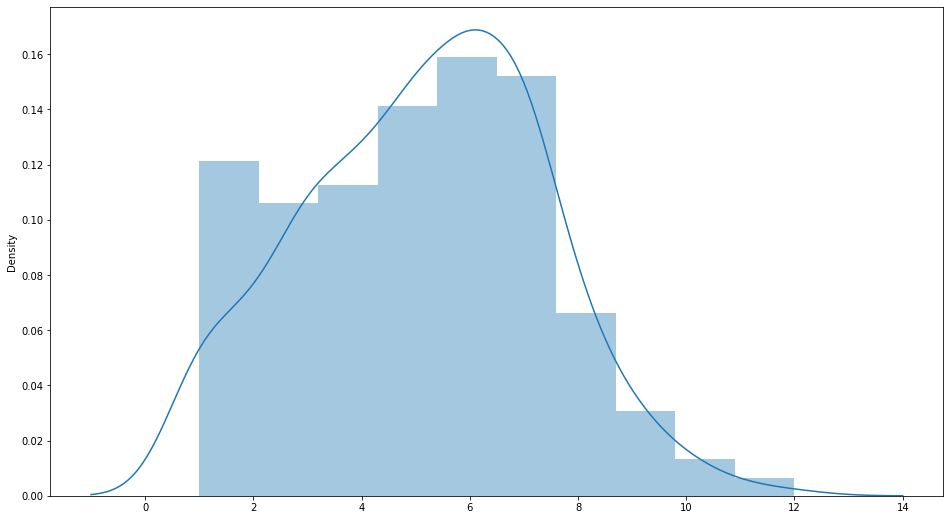

In [162]:
queen_card = pd.Series(w_queen.cardinalities)
sns.distplot(queen_card, bins=10)
# the size of neighborhoods in general

In [163]:
# Number of observations
w_queen.n

412

In [164]:
# Average number of neighbors
w_queen.mean_neighbors

5.160194174757281

In [165]:
# Min number of neighbors
w_queen.min_neighbors

1

In [166]:
# Max number of neighbors
w_queen.max_neighbors

12

In [167]:
w_queen.transform = 'R'

In [119]:
w_queen[1]

{8: 0.5, 7: 0.5}

In [121]:
w_queen.transform = 'O'
w_queen.transform = 'R'

In [124]:
# Compute spatial lag of `imd_score`
w_queen_score = ps.lib.weights.lag_spatial(w_queen, gdf['Anzahl'])
w_queen_score[:5]
gdf['w_queen_score'] = w_queen_score

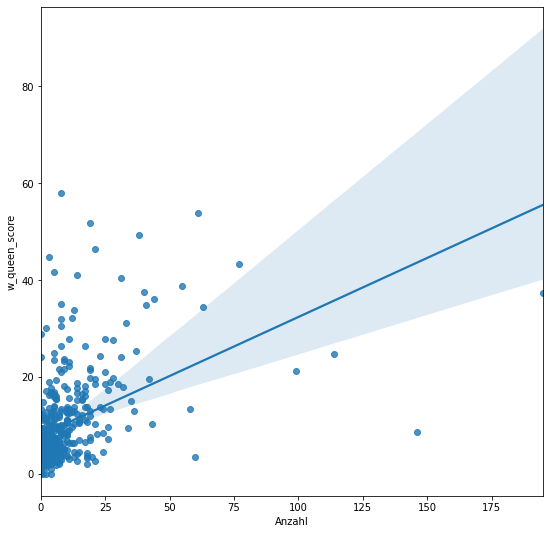

In [125]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x="Anzahl", y="w_queen_score", data=gdf)
# Display
plt.show()

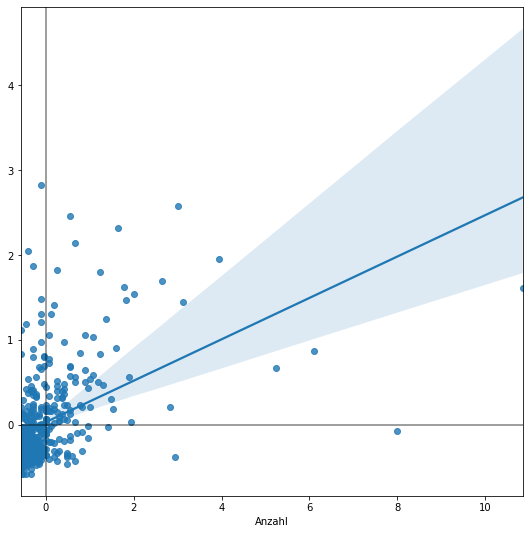

In [130]:
# Standardize 
std_gdf = (gdf['Anzahl'] - gdf['Anzahl'].mean()) / gdf['Anzahl'].std()
std_w_gdf = pd.Series(ps.lib.weights.lag_spatial(w_queen, std_gdf), index=std_gdf.index)

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_gdf, y=std_w_gdf)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [132]:
thresh = ps.lib.weights.min_threshold_distance(pts)
thresh

0.7407107700790917

In [133]:
# https://stackoverflow.com/questions/63216115/local-morans-index-using-pysal
w_distC_from_pts = ps.lib.weights.DistanceBand.from_array(pts, thresh, binary = False) #300000

C:\Users\wolfg\Anaconda3\envs\webscraping\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning:

The weights matrix is not fully connected. There are 2 components



In [134]:
w_distC_from_pts[0]

{4: 1.3696371385843675,
 5: 1.7594568081250916,
 8: 1.659326416441561,
 9: 5.749395157879028}

In [135]:
w_distC_from_pts.transform = 'R'

In [136]:
pd.Series(w_distC_from_pts[0]).sum()

1.0

In [144]:
# mi = Moran(gdf['Anzahl'], w_distC_from_pts)
mi = Moran(gdf['Anzahl'], w_queen)

In [145]:
mi.I, mi.p_sim, mi.z_sim

(0.24384598028249088, 0.001, 7.622272278899722)

In [168]:
dict_list = []

# w_queen = ps.lib.weights.contiguity.Queen(gdf['geometry'])

for date in tqdm(complete_week_df.index.unique()):
    
    empty_dict = {}
    
    sub_df = complete_week_df.loc[date].merge(landkreis_data, left_on='RS', right_on = 'RS', how = 'left')[['IdLandkreis', 'Anzahl', 'was_missing']]
    sub_df = sub_df.merge(final_pop_df, left_on='IdLandkreis', right_on = 'RS', how = 'left')
    sub_gdf = gpd.GeoDataFrame(sub_df, geometry=sub_df['geometry'])
    sub_gdf.crs = 'epsg:4326'
    sub_gdf['Anzahl'] = sub_gdf['Anzahl'].astype(int)
    
    # w_queen = ps.lib.weights.contiguity.Queen(gdf['geometry'])
    mi = Moran(sub_gdf['Anzahl'], w_queen)
    
    empty_dict['Morans_I'] = mi.I
    
    empty_dict['p_sim'] = mi.p_sim
    
    empty_dict['Date'] = date
    
    empty_dict['z_sim'] = mi.z_sim
    
    dict_list.append(empty_dict)

morans_df = pd.DataFrame(dict_list)

  0%|          | 0/277 [00:00<?, ?it/s]

<AxesSubplot:>

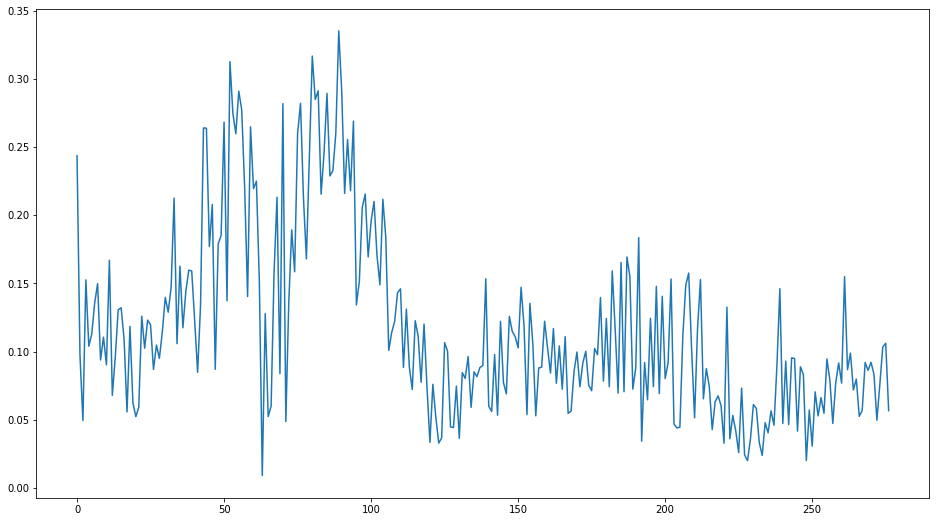

In [170]:
morans_df['Morans_I'].plot()

In [189]:
complete_week_df['Anzahl'] = complete_week_df['Anzahl'].astype(int)
complete_week_df.set_index(complete_week_df.index).resample('D')['Anzahl'].sum()

2020-03-20     4057
2020-03-21        0
2020-03-22        0
2020-03-23     3730
2020-03-24     4882
              ...  
2021-04-08    25626
2021-04-09    22939
2021-04-10        0
2021-04-11        0
2021-04-12     7167
Freq: D, Name: Anzahl, Length: 389, dtype: int32

In [196]:
total_list = []

for day in complete_week_df.index.unique():
    
    sub_df = complete_week_df.loc[day]
    total = sub_df['Anzahl'].sum()
    
    total_list.append(total)

In [201]:
np.array(total_list).sum()

2420746

<AxesSubplot:>

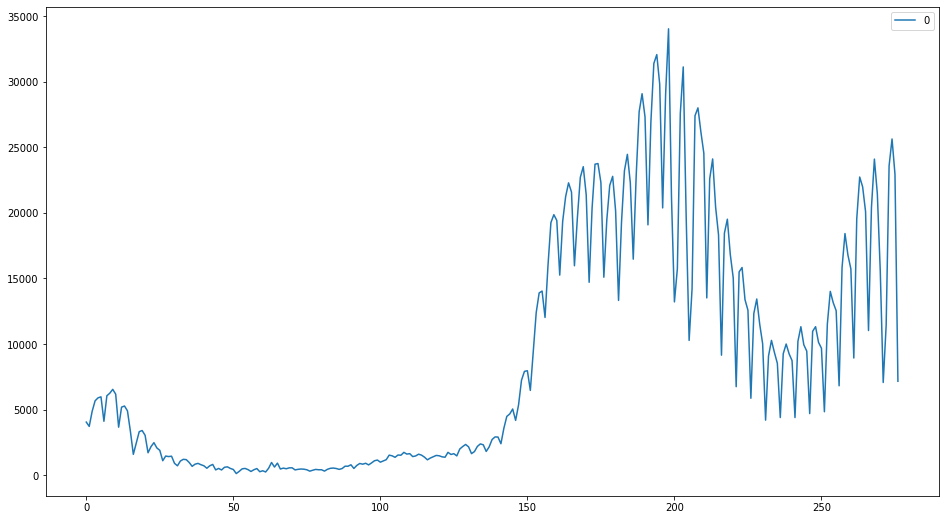

In [203]:
pd.DataFrame(total_list).plot()

In [71]:
corona_data[(corona_data['Meldedatum'] > '2021-04-05') & 
            (corona_data['Meldedatum'] <= '2021-04-12') & 
            (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

4389

In [72]:
corona_data[(corona_data['Meldedatum'] == '2021-04-11') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

98

In [73]:
corona_data[(corona_data['Meldedatum'] == '2021-04-12') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

384

In [74]:
corona_data[(corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

153981

In [75]:
corona_data[(corona_data['Bundesland'] == 'Berlin')]['AnzahlTodesfall'].sum()

3126

1. Aggregate by day on Landkreis level

In [78]:
grouped_df = corona_data.groupby(['Landkreis', 'MeldedatumISO'])[['AnzahlFall']].agg('sum')
grouped_df = grouped_df.stack().to_frame().reset_index()

In [79]:
grouped_df.head()

,Landkreis,MeldedatumISO,level_2,0
0,LK Ahrweiler,2020-03-12,AnzahlFall,6
1,LK Ahrweiler,2020-03-13,AnzahlFall,3
2,LK Ahrweiler,2020-03-14,AnzahlFall,1
3,LK Ahrweiler,2020-03-16,AnzahlFall,4
4,LK Ahrweiler,2020-03-17,AnzahlFall,6


In [98]:
# grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Reinickendorf') & (grouped_df['MeldedatumISO'] == '2021-04-12')]
grouped_df.columns = ['Landkreis', 'MeldedatumISO', 'Indicator', 'Anzahl']

In [101]:
grouped_df

,Landkreis,MeldedatumISO,Indicator,Anzahl
0,LK Ahrweiler,2020-03-12,AnzahlFall,6
1,LK Ahrweiler,2020-03-13,AnzahlFall,3
2,LK Ahrweiler,2020-03-14,AnzahlFall,1
3,LK Ahrweiler,2020-03-16,AnzahlFall,4
4,LK Ahrweiler,2020-03-17,AnzahlFall,6
...,...,...,...,...
122101,StadtRegion Aachen,2021-04-08,AnzahlFall,102
122102,StadtRegion Aachen,2021-04-09,AnzahlFall,174
122103,StadtRegion Aachen,2021-04-10,AnzahlFall,70
122104,StadtRegion Aachen,2021-04-11,AnzahlFall,17


In [88]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-12')]['Anzahl'].sum()

45

In [89]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-11')]['Anzahl'].sum()

0

In [90]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-10')]['Anzahl'].sum()

0

In [91]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-09')]['Anzahl'].sum()

119

In [92]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-08')]['Anzahl'].sum()

166

In [93]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-07')]['Anzahl'].sum()

67

In [94]:
grouped_df[(grouped_df['Landkreis'] == 'SK Berlin Mitte') & (grouped_df['MeldedatumISO'] == '2021-04-06')]['Anzahl'].sum()

115

In [97]:
45 + 0 + 0 + 119 + 166 + 67 + 115

512

In [46]:
corona_data.set_index(pd.to_datetime(df['Publication date'], format='%d.%m.%Y'), inplace = True)

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,geometry,MeldedatumISO
0,1,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-09-30T00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-09-30T00:00:00+00:00,0,1,0,Nicht übermittelt,None,2020-09-30
1,2,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-10-29T00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-10-29T00:00:00+00:00,0,1,0,Nicht übermittelt,None,2020-10-29
2,3,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-03T00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-11-03T00:00:00+00:00,0,1,0,Nicht übermittelt,None,2020-11-03
3,4,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-20T00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-11-19T00:00:00+00:00,0,1,1,Nicht übermittelt,None,2020-11-20
4,5,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020-11-23T00:00:00+00:00,01001,"13.04.2021, 00:00 Uhr",0,-9,2020-11-18T00:00:00+00:00,0,1,1,Nicht übermittelt,None,2020-11-23


In [36]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-12') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

384

In [37]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-11') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

98

In [39]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-10') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

487

In [40]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-09') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

1071

In [41]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-08') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

988

In [42]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-07') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

737

In [43]:
corona_data[(corona_data['MeldedatumISO'] == '2021-04-06') & (corona_data['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

624

In [44]:
384 + 98 + 487 + 1071 + 988 + 737 + 624

4389

In [47]:
seed = 'https://storage.googleapis.com/brdata-public-data/rki-corona-archiv/2_parsed/index.html'
html = requests.get(seed)

soup = BeautifulSoup(html.text, "html.parser")

target_url = soup.find_all('a')[-1].get('href')
target_url

response = requests.get(target_url)

if response.status_code == 200:
    with open("latest_RKI_data.ndjson.xz", 'wb') as f:
        f.write(response.content)
        
import lzma
from tqdm.notebook import tqdm

num_lines = sum(1 for line in lzma.open('latest_RKI_data.ndjson.xz', mode='rt'))

empty_list = []

with lzma.open('latest_RKI_data.ndjson.xz', mode='rt', encoding = 'utf-8') as file:
 
    counter = 0
    
    for line in tqdm(file, total = num_lines):
        
        empty_list.append(json.loads(line))
        
        if counter < 5:
        
            print(line)
            
        counter += 1

In [54]:
corona_df = pd.DataFrame(empty_list)

In [55]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-12') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

384

In [56]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-11') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

98

In [57]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-10') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

487

In [58]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-09') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

1071

In [59]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-08') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

988

In [60]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-07') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

737

In [61]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-06') & (corona_df['Bundesland'] == 'Berlin')]['AnzahlFall'].sum()

624

In [62]:
384 + 98 + 487 + 1071 + 988 + 737 + 624

4389

In [45]:
# corona_df.set_index(pd.to_datetime(corona_df['MeldedatumISO'], format='%Y-%m-%d'), inplace = True)

In [12]:
corona_df[corona_df['MeldedatumISO'] == '2021-04-11']

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,...,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,MeldedatumISO,DatenstandISO,RefdatumISO
131,132,1,Schleswig-Holstein,SK Flensburg,A05-A14,M,1,0,2021/04/11 00:00:00,01001,...,1,-9,2021/04/11 00:00:00,-9,0,0,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11
842,843,1,Schleswig-Holstein,SK Flensburg,A15-A34,W,1,0,2021/04/11 00:00:00,01001,...,1,-9,2021/04/04 00:00:00,-9,0,1,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-04
843,844,1,Schleswig-Holstein,SK Flensburg,A15-A34,W,1,0,2021/04/11 00:00:00,01001,...,1,-9,2021/04/09 00:00:00,-9,0,1,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-09
844,845,1,Schleswig-Holstein,SK Flensburg,A15-A34,W,1,0,2021/04/11 00:00:00,01001,...,1,-9,2021/04/11 00:00:00,-9,0,0,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11
845,846,1,Schleswig-Holstein,SK Flensburg,A15-A34,W,1,0,2021/04/11 00:00:00,01001,...,1,-9,2021/04/11 00:00:00,-9,0,1,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630949,1630950,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2021/04/11 00:00:00,16077,...,1,-9,2021/04/11 00:00:00,-9,0,0,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11
1631159,1631160,16,Thüringen,LK Altenburger Land,A80+,W,1,0,2021/04/11 00:00:00,16077,...,1,-9,2021/04/11 00:00:00,-9,0,0,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11
1631170,1631171,16,Thüringen,LK Altenburger Land,A35-A59,M,3,0,2021/04/11 00:00:00,16077,...,1,-9,2021/04/11 00:00:00,-9,0,0,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11
1631474,1631475,16,Thüringen,LK Altenburger Land,A35-A59,W,3,0,2021/04/11 00:00:00,16077,...,1,-9,2021/04/11 00:00:00,-9,0,0,Nicht übermittelt,2021-04-11,2021-04-12,2021-04-11


In [121]:
corona_df.tail()

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,...,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,MeldedatumISO,DatenstandISO,RefdatumISO
1626435,1626436,16,Thüringen,LK Altenburger Land,A80+,W,3,0,2021/04/07 00:00:00,16077,...,0,-9,2021/04/07 00:00:00,-9,0,0,Nicht übermittelt,2021-04-07,2021-04-11,2021-04-07
1626436,1626437,16,Thüringen,LK Altenburger Land,A80+,W,7,0,2021/04/08 00:00:00,16077,...,0,-9,2021/04/08 00:00:00,-9,0,0,Nicht übermittelt,2021-04-08,2021-04-11,2021-04-08
1626437,1626438,16,Thüringen,LK Altenburger Land,A80+,W,1,0,2021/04/09 00:00:00,16077,...,1,-9,2021/04/09 00:00:00,-9,0,0,Nicht übermittelt,2021-04-09,2021-04-11,2021-04-09
1626438,1626439,16,Thüringen,LK Altenburger Land,A80+,W,4,0,2021/04/09 00:00:00,16077,...,0,-9,2021/04/09 00:00:00,-9,0,0,Nicht übermittelt,2021-04-09,2021-04-11,2021-04-09
1626439,1626440,16,Thüringen,LK Altenburger Land,unbekannt,unbekannt,1,0,2021/04/06 00:00:00,16077,...,0,-9,2021/04/06 00:00:00,-9,0,0,Nicht übermittelt,2021-04-06,2021-04-11,2021-04-06


In [122]:
corona_df[(corona_df['MeldedatumISO'] == '2021-04-04') & (corona_df['NeuerTodesfall'] == 1)]

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,...,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,MeldedatumISO,DatenstandISO,RefdatumISO
786423,786424,8,Baden-Württemberg,LK Schwäbisch Hall,A80+,W,1,1,2021/04/04 00:00:00,08127,...,0,1,2021/03/27 00:00:00,-9,0,1,Nicht übermittelt,2021-04-04,2021-04-11,2021-03-27
1437118,1437119,14,Sachsen,LK Erzgebirgskreis,A60-A79,M,1,1,2021/04/04 00:00:00,14521,...,0,1,2021/04/04 00:00:00,-9,0,0,Nicht übermittelt,2021-04-04,2021-04-11,2021-04-04
1527932,1527933,15,Sachsen-Anhalt,LK Altmarkkreis Salzwedel,A80+,M,1,1,2021/04/04 00:00:00,15081,...,0,1,2021/04/01 00:00:00,-9,0,1,Nicht übermittelt,2021-04-04,2021-04-11,2021-04-01


In [102]:
grouped_df = pd.DataFrame(corona_df.groupby(['MeldedatumISO','Bundesland']).count()['ObjectId'])
grouped_df = grouped_df.stack().to_frame().reset_index()

In [103]:
res = grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-04')]
res

<bound method NDFrame.head of      MeldedatumISO           Bundesland   level_2  0
4016    2021-04-04    Baden-Württemberg  ObjectId  2
4017    2021-04-04               Bayern  ObjectId  3
4018    2021-04-04               Berlin  ObjectId  1
4019    2021-04-04          Brandenburg  ObjectId  1
4020    2021-04-04        Niedersachsen  ObjectId  3
4021    2021-04-04  Nordrhein-Westfalen  ObjectId  3
4022    2021-04-04              Sachsen  ObjectId  2
4023    2021-04-04       Sachsen-Anhalt  ObjectId  1>

In [100]:
res.columns = ['Datum', 'Bundesland', 'Bla', 'Count Num']

In [101]:
res['Count Num'].sum()

16

In [85]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-04') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6264,2021-04-04,Thüringen,ObjectId,117


In [73]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-05') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6280,2021-04-05,Thüringen,ObjectId,130


In [74]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-06') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6296,2021-04-06,Thüringen,ObjectId,238


In [75]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-07') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6312,2021-04-07,Thüringen,ObjectId,360


In [76]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-08') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6328,2021-04-08,Thüringen,ObjectId,343


In [77]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-09') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6344,2021-04-09,Thüringen,ObjectId,321


In [78]:
grouped_df[(grouped_df['MeldedatumISO'] == '2021-04-10') & (grouped_df['Bundesland'] == 'Thüringen')]

,MeldedatumISO,Bundesland,level_2,0
6360,2021-04-10,Thüringen,ObjectId,161
